In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.math import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

2024-04-06 16:29:19.353038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 16:29:19.353226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 16:29:19.567899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
bank_df_train = pd.read_csv('/kaggle/input/bank-dataset/bank_train.csv')
bank_df_train.columns = ['Comments', 'Intend']
bank_df_train.head()

,Comments,Intend
0,I OPENED A NEW ACCOUNT IN YOUR BANK BUT WHEN I...,1
1,I APPLIED FOR DEBIT OR CREDIT CARD WHEN I OPEN...,0
2,TILL NOW I DID NOT GET ANY DEBIT OR CREDIT CAR...,0
3,I GAVE AN APPLICATION FOR LINKING UNIQUE NUMBE...,1
4,I WANT TO CHANGE THE MOBILE NUMBER THAT WAS PR...,1


In [3]:
bank_df_test = pd.read_csv('/kaggle/input/bank-dataset/bank_test.csv')
bank_df_test.columns = ['Comments', 'Intend']

In [4]:
intend_classes = {
    0:'User Information related issue', 
    1:'Debit/Credit card related issues',
    2:'Transaction related issues'
}

In [5]:
def tokenize_text(s):
    res = nltk.word_tokenize(s.lower())
    return res

bank_df_train['Comments'] = bank_df_train['Comments'].map(tokenize_text)
bank_df_test['Comments'] = bank_df_test['Comments'].map(tokenize_text)

In [6]:
def remove_stopwords(ls):
    stopwords_dict = nltk.corpus.stopwords.words('english')
    res = [i for i in ls if i not in stopwords_dict]
    return res

bank_df_train['Comments'] = bank_df_train['Comments'].map(remove_stopwords)
bank_df_test['Comments'] = bank_df_test['Comments'].map(remove_stopwords)

In [7]:
def stemming(ls):
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    stem_words = [porter_stemmer.stem(i) for i in ls]
    return stem_words

bank_df_train['Comments'] = bank_df_train['Comments'].map(stemming)
bank_df_test['Comments'] = bank_df_test['Comments'].map(stemming)

In [8]:
def get_data(train_df, test_df):
    
    # Converting text tokens to sequence tokens
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(train_df.Comments)
    
    train_tokenized_data = text_tokenizer.texts_to_sequences(train_df.Comments)
    test_tokenized_data = text_tokenizer.texts_to_sequences(test_df.Comments)
    
    max_len = max(len(i) for i in train_tokenized_data)
    print('Max length: ', max_len)
    
    train_data = pad_sequences(train_tokenized_data, maxlen=max_len, padding='pre')
    test_data = pad_sequences(test_tokenized_data, maxlen=max_len, padding='pre')
    
    return text_tokenizer, max_len, train_data, test_data

text_tokenizer, max_len, train_data, test_data = get_data(bank_df_train, bank_df_test)

Max length:  27


In [9]:
y = tf.one_hot(bank_df_train['Intend'].values, 3)

In [10]:
model = tf.keras.Sequential([
    Input((27,)),
    Embedding(204, 32),
    LSTM(units=10),
    Dropout(0.2),
    Dense(units = 3, activation='sigmoid')  
])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', 'auc'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 27, 32)         │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │         1,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,281 (32.35 KB)

 Trainable params: 8,281 (32.35 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    monitor='val_auc',
    restore_best_weights = True,
)

In [14]:
model.fit(
    x = train_data,
    y = y,
    validation_split=0.1,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.3199 - auc: 0.4641 - loss: 1.0996 - val_accuracy: 0.0000e+00 - val_auc: 0.5312 - val_loss: 1.0972
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5559 - auc: 0.7203 - loss: 1.0869 - val_accuracy: 0.2500 - val_auc: 0.6172 - val_loss: 1.0915
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6489 - auc: 0.8331 - loss: 1.0678 - val_accuracy: 0.7500 - val_auc: 0.6836 - val_loss: 1.0837
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7321 - auc: 0.8936 - loss: 1.0521 - val_accuracy: 0.7500 - val_auc: 0.7266 - val_loss: 1.0778
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7016 - auc: 0.8722 - loss: 1.0430 - val_accuracy: 0.7500 - val_auc: 0.7695 - val_loss: 1.0708
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6938 - auc: 0.8881 - loss: 1.0117 - val_accuracy: 0.6250 - val_auc: 0.7578 - val_loss: 1.0639
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/st

In [15]:
y_pred = model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


In [16]:
conf = confusion_matrix(
    bank_df_test['Intend'].values, 
    np.argmax(y_pred, axis=1),
)

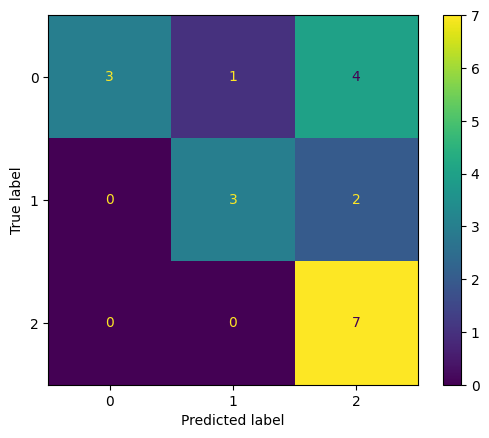

In [17]:
disp = ConfusionMatrixDisplay(
    conf,
    display_labels=[0, 1, 2]
)
disp.plot()
plt.show()